<a href="https://colab.research.google.com/github/ououou92/ooo/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#HW03 Data Analysis

##Customer Segmentation FM Analysis

##摘要

在行銷管理學裡有一項工具，可協助公司找出不同類型顧客，這項工具稱為「RFM模型」。本報告基於 `Ta Feng Grocery Dataset` 這個超市的交易資料，依據消費頻率（Frequency）、與消費金額（Monetary）這兩個指標進行市場區隔，再進一步分析各群顧客背後的消費行為，作為制定行銷策略的依據

##引言

###背景
以往一家小企業只要經營一段期間，只要老闆、老闆娘或是第一線銷售員工的記憶力不差，大概就可以把上門的顧客區分成三大類型，他們分別是「新客（最近曾經前來消費的客人）」、「常客（經常前來消費的客人）」，以及「貴客（消費金額大的重要客人）」，但是，一旦企業大到一定規模，或是顧客上千上萬人時，恐怕記憶力再好，也無法因應，這時，就需要靠資料分析來協助。
###目的
透過資料分析，將 `Ta Feng Grocery Dataset` 這個超市的80萬筆交易項目計錄，彙整成11萬筆訂單，再彙整成3萬筆顧客資料，再依照消費頻率（Frequency）、與消費金額（Monetary）做顧客分群，並了解分群後的各群體消費行為作為制定行銷策略的依據
###待答問題
1. 發現的商業洞見?
2. 各族群特徵為何?


## 方法

### 數據來源
本研究使用`Ta Feng Grocery Dataset`虛擬超市數據集https://www.kaggle.com/chiranjivdas09/ta-feng-grocery-dataset
#### 變數有
- TRANSACTION_DT: 日期
- CUSTOMER_ID: 顧客ID
- AGE_GROUP: 年齡層級
- PIN_CODE: 郵遞區號
- PRODUCT_SUBCLASS: 品類
- PRODUCT_ID: 品項
- AMOUNT: 數量
- ASSET: (總)成本
- SALES_PRICE: (總)售價

### 分析工具
- **Python**（數據處理與分析）
- **Pandas**（數據清理與統計分析）
- **Matplotlib / Seaborn**（數據視覺化）

### 數據處理
1. 載入 `Ta Feng Grocery Dataset` 數據集並將變數名稱簡化，處理日期年齡區間和outliers

In [4]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Python equivalent for R transaction data analysis
Z = pd.read_csv("/content/ta_feng_all_months_merged.csv")
Z.columns = ["date", "cust", "age", "area", "cat", "prod", "qty", "cost", "price"]
# Convert date
Z['date'] = pd.to_datetime(Z['date'], format='%m/%d/%Y')
# Age group conversion
age_group = ["<25","25-29","30-34","35-39","40-44", "45-49","50-54","55-59","60-64",">65"]
age_map = {k: f"a{v}" for k, v in zip(age_group, list(range(24, 69, 5)) + [99])}
Z['age'] = Z['age'].map(age_map).fillna('a99')
Z['area'] = 'z' + Z['area'].astype(str)
# Remove outliers
Z = Z[(Z['qty'] <= 24) & (Z['cost'] <= 3800) & (Z['price'] <= 4000)]

2. 將80萬筆交易項目計錄，彙整成11萬筆訂單，再彙整成3萬筆顧客資料

In [5]:
# Assign transaction ID
Z['tid'] = Z.groupby(['date', 'cust']).ngroup()
# Summary
X = Z.groupby('tid').agg(
    date=('date', 'min'),
    cust=('cust', 'min'),
    age=('age', 'min'),
    area=('area', 'min'),
    items=('prod', 'count'),
    pieces=('qty', 'sum'),
    total=('price', 'sum'),
    per=('price', lambda x: x.sum()/Z.loc[x.index, 'qty'].sum()),
    gross=('price', lambda x: (x - Z.loc[x.index, 'cost']).sum())
).reset_index()
# Remove outliers
X = X[(X['items'] <= 62) & (X['pieces'] < 95) & (X['total'] < 16000)]
# Customer aggregation
d0 = X['date'].max() + timedelta(days=1)
X['days'] = (d0 - X['date']).dt.days
A = X.groupby('cust').agg(
    r=('days', 'min'),
    s=('days', 'max'),
    f=('tid', 'count'),
    m=('total', 'mean'),
    rev=('total', 'sum'),
    raw=('gross', 'sum'),
    age=('age', 'min'),
    area=('area', 'min')
).reset_index()

3. 顧客分群
- VIP: 消費頻率和消費金額都很高者
- LOYAL: 消費頻率高且消費金額低
- POTENTIAL: 消費頻率低且消費金額高
- ELSE: 消費頻率低且消費金額低

In [6]:
# Calculate quantiles for f and m
f_quantiles = A['f'].quantile([0.2, 0.4, 0.6, 0.8])
m_quantiles = A['m'].quantile([0.2, 0.4, 0.6, 0.8])

# Function to assign segments based on quantiles
def assign_segment(value, quantiles, prefix):
    if value >= quantiles[0.8]:
        return prefix + '5'
    elif value >= quantiles[0.6]:
        return prefix + '4'
    elif value >= quantiles[0.4]:
        return prefix + '3'
    elif value >= quantiles[0.2]:
        return prefix + '2'
    else:
        return prefix + '1'

# Apply the function to create segments
A['f_segment'] = A['f'].apply(lambda x: assign_segment(x, f_quantiles, 'F'))
A['m_segment'] = A['m'].apply(lambda x: assign_segment(x, m_quantiles, 'M'))

# Combine segments into FM_group
A['FM_group'] = A['f_segment'] + A['m_segment']

# Assign Type based on FM_group
conditions = [
    A['FM_group'].isin(['F5M5', 'F5M4', 'F4M5', 'F4M4']),
    A['FM_group'].str.startswith(('F4','F5')) & A['FM_group'].str.endswith(('M1','M2','M3')),
    A['FM_group'].str.startswith(('F1','F2','F3')) & A['FM_group'].str.endswith(('M4','M5')),
    A['FM_group'] == 'F1M1',
]
choices = ['VIP', 'LOYAL', 'POTENTIAL', 'LOST']
A['Type'] = np.select(conditions, choices, default='ELSE')

print(A.head(20))

    cust    r    s   f            m    rev   raw  age     area f_segment  \
0   1069   19  108   4   486.000000   1944    15  a99     z115        F4   
1   1113   54  109   4   557.500000   2230   241  a99     z221        F4   
2   1250   19   25   2   791.500000   1583   354  a39     z114        F3   
3   1359   87   87   1   364.000000    364   104  a99  zOthers        F2   
4   1823   36  119   3   869.000000   2607   498  a99     z114        F4   
5   2189   57   89   2  7028.000000  14056  3299  a99     z106        F3   
6   3667   21   83   4  1582.250000   6329   727  a99  zOthers        F4   
7   4282   47   76   2   483.500000    967   179  a99     z115        F3   
8   4381  103  103   1   701.000000    701   165  a39  zOthers        F2   
9   4947   81   88   2  1681.500000   3363   479  a99     z114        F3   
10  4961   24   24   1   553.000000    553   122  a39     z221        F2   
11  4978   38   57   2  1222.500000   2445   551  a99     z114        F3   
12  5241   1

# 結果與分析

###各個Type的人數比例

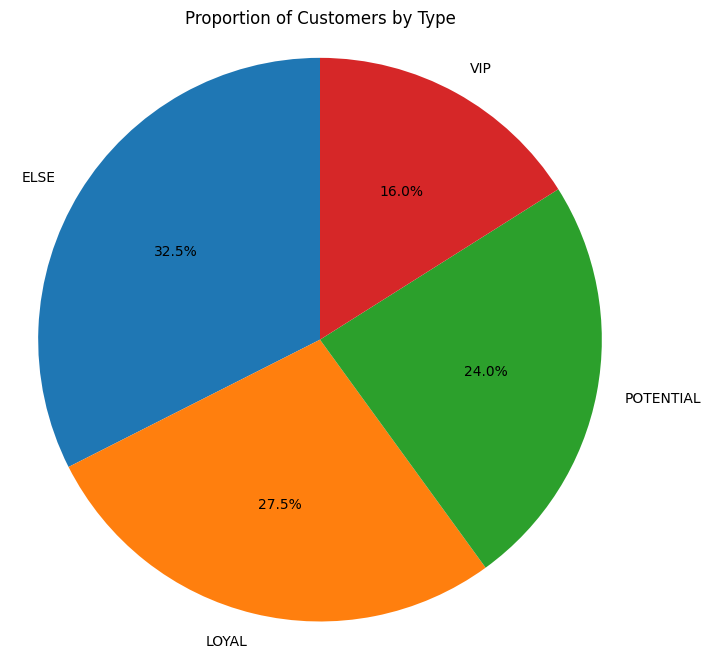

In [7]:
# Count the occurrences of each type
type_counts = A['Type'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Customers by Type')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


###各個族群的平均客單價和平均消費頻率點狀圖

以點狀圖檢視分群結果與設定是否相符

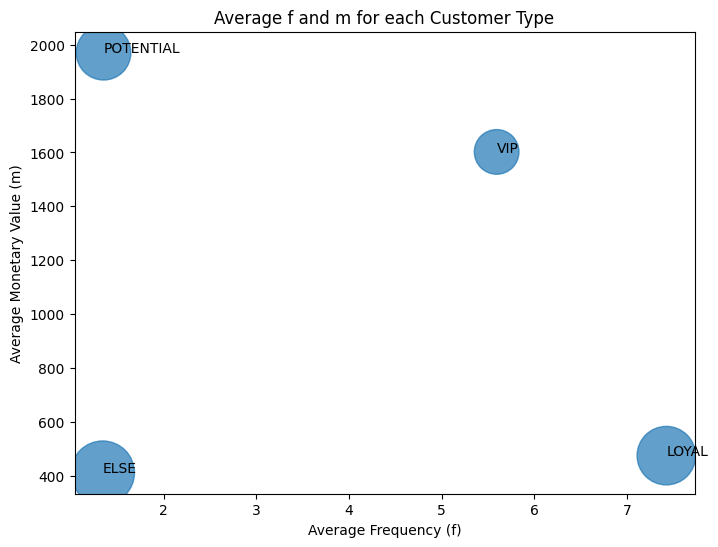

In [8]:
# Calculate the average f and m for each Type
type_avg = A.groupby('Type').agg({'f': 'mean', 'm': 'mean', 'cust': 'count'})

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(type_avg['f'], type_avg['m'], s=type_avg['cust']/5, alpha=0.7)  # Adjust s for point size

# Add labels and title
plt.xlabel('Average Frequency (f)')
plt.ylabel('Average Monetary Value (m)')
plt.title('Average f and m for each Customer Type')


# Add annotations for each point
for i in range(len(type_avg)):
    plt.annotate(type_avg.index[i], (type_avg['f'].iloc[i], type_avg['m'].iloc[i]))


plt.show()


**分析結果**：
- 各族群的消費行為與設定一致，且群間差異相當大

### 星期幾消費比例柱狀圖

比較不同族群偏好的消費時間

In [9]:
# Convert 'date' column to datetime objects and extract the day of the week
A['date'] = pd.to_datetime(A['date'])
A['day_of_week'] = A['date'].dt.dayofweek  # Monday=0, Sunday=6

# Group data by 'Type' and 'day_of_week' and count transactions
day_counts = A.groupby(['Type', 'day_of_week']).size().unstack(fill_value=0)

# Normalize to percentages for each type
day_percentages = day_counts.div(day_counts.sum(axis=1), axis=0) * 100

# Plotting
plt.figure(figsize=(10, 6))
day_percentages.plot(kind='bar', stacked=True)
plt.title('Proportion of Transactions by Day of the Week for Each Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Percentage of Transactions')
plt.xticks(rotation=0)
plt.legend(title='Day of the Week', labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.tight_layout()
plt.show()


KeyError: 'date'

**分析結果**：
- LOYAL族群在不同天消費的比例相較之下較均勻
- POTENTIAL族群在假日消費的比例較高

###居住地比例柱狀圖

In [ ]:
# Calculate the proportion of customers in each area for each customer type
area_proportions = A.groupby(['Type', 'area']).size().unstack(fill_value=0)
area_proportions = area_proportions.div(area_proportions.sum(axis=1), axis=0) * 100

# Plotting
plt.figure(figsize=(12, 6))
area_proportions.plot(kind='bar', stacked=True)
plt.title('Proportion of Customers by Area for Each Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Percentage of Customers')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Area', bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside the plot
plt.tight_layout()
plt.show()


**分析結果**
- LOYAL為消費頻率高的族群,居住於Z115和Z221的比例對比消費頻率低的族群如POTENTIAL高出很多

## 結論與建議

- ELSE和LOTAL族群平均消費金額約在400到600之間，可以設定消費金額700可以折70的活動，以提高這兩族群的平均客單價
- POTENTIAL族群平均消費頻率較低且平均客單價為2000，可以設定消費金額達到2100贈折價券鼓勵其常來
- 不論哪個族群，住在Z115和Z221的比例都較高，可以推測這兩地與商店位置較近
- 消費頻率高的族群LOYAL住在Z115和Z221的比例較高，消費頻率低的族群POTENTIAL住在Z115和Z221的比例較低，在Z115和Z221這兩地與商店位置較近的假設成立下，可以推測距離可能會影響購買頻率
